In [34]:
import os
import sys

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.io import loadmat
# from matplotlib.ticker import MultipleLocator
# import nibabel as nib
# import pickle
# from importlib import reload
# import h5py
# from nilearn import plotting
# import nibabel as nib

import torch
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from torch.nn import Module
from matplotlib import colormaps
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA




# from sklearn.cross_decomposition import PLSRegression
# import seaborn as sns
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import KFold, cross_val_predict
# from sklearn.metrics import r2_score

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

from funcs.imgproc import rand_img_list, show_stim, get_imgs_designmx



['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


In [18]:
# Load the pretrained AlexNet model
model = models.alexnet(pretrained=True)
model.eval()  # Set the model to evaluation mode


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
class AlexNetFeatureExtractorConv(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractorConv, self).__init__()
        # Assuming you want to capture outputs after each max pooling layer
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:1])  # Up to first max pooling
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[1:4])  # Up to second max pooling
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[4:6])  # Up to third max pooling
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[6:8])  # Up to fourth max pooling
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[8:11])  # Up to fifth max pooling

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1, x2, x3, x4, x5

feature_extractor_conv = AlexNetFeatureExtractorConv(model)

In [41]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, image_ids, transform=None):
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        imgnp = show_stim(img_no=img_id, hide='y', small = 'y')[0][163:263,163:263]
        imgPIL = Image.fromarray(imgnp) # Convert into PIL from np

        if self.transform:
            imgPIL = self.transform(imgPIL)

        return imgPIL
    
preprocess = transforms.Compose([
    transforms.Resize(227),  # Resize the image to 227x227 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
image_ids = get_imgs_designmx()['subj01'][:100]
dataset = ImageDataset(image_ids, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)



    
#     imgnp = show_stim(img_no=this_img, hide='y', small = 'y')[0][163:263,163:263]
#     imgPIL = Image.fromarray(imgnp) # Convert into PIL from np
#     img_tensor = preprocess(imgPIL).unsqueeze(0)  # Add batch dimension

In [42]:
from sklearn.preprocessing import StandardScaler


class AlexNetFeatureExtractorReLU(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractorReLU, self).__init__()
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:2])
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[2:5])
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[5:7])
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[7:9])
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[9:12])
        # self.layer1 = torch.nn.Sequential(*list(self.features.children())[:2])  # Up to first max pooling
        # self.layer2 = torch.nn.Sequential(*list(self.features.children())[2:5])  # Up to second max pooling
        # self.layer3 = torch.nn.Sequential(*list(self.features.children())[5:7])  # Up to third max pooling
        # self.layer4 = torch.nn.Sequential(*list(self.features.children())[7:9])  # Up to fourth max pooling
        # self.layer5 = torch.nn.Sequential(*list(self.features.children())[9:12])  # Up to fifth max pooling

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)

        return x1, x2, x3, x4, x5

# Initialize your model
pca_feats_relu = AlexNetFeatureExtractorReLU(model)

# Collect the features of each layer for multiple samples
features = []

for batch in dataloader:
    img_tensor = (batch)  # Add batch dimension and move to GPU


    x1, x2, x3, x4, x5 = pca_feats_relu(img_tensor)
        
    features.append((x1.view(x1.size(0), -1).detach().numpy(), 
                        x2.view(x2.size(0), -1).detach().numpy(), 
                        x3.view(x3.size(0), -1).detach().numpy(), 
                        x4.view(x4.size(0), -1).detach().numpy(), 
                        x5.view(x5.size(0), -1).detach().numpy()))

pca_list = []  # List to store PCA objects for each layer
for i in range(5):
    layer_features = np.concatenate([feat[i] for feat in features], axis=0)
    # Scale the features

    # Initialize and fit PCA for this layer
    pca = PCA(n_components=.95, svd_solver='full')  # Adjust as needed
    layer_features_pca = pca.fit_transform(layer_features)

    pca_list.append(pca)  # Store the PCA object for later use

# Initialize a new StandardScaler for each layer
scaler_list = [StandardScaler() for _ in range(5)]

# Get the PCs for each layer
pcs_list = []
for i in range(5):
    # Get the features of the i-th layer for all images
    layer_features = np.concatenate([feat[i] for feat in features], axis=0)
    # Fit and transform the StandardScaler on the features
    scaler = scaler_list[i]
    layer_features_scaled = scaler.fit_transform(layer_features)
    # Get the PCA object for this layer
    pca = pca_list[i]
    # Apply PCA to the scaled features
    layer_features_pca = pca.transform(layer_features_scaled)
    # Add the PCs to the list
    pcs_list.append(layer_features_pca)
    
pcs_list[4].shape

(100, 81)

In [48]:
pcs_list[0][0].shape

(74,)

In [271]:
class AlexNetFeatureExtractorReLU(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractorReLU, self).__init__()
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:2])
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[2:5])
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[5:7])
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[7:9])
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[9:12])

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)

        # Apply PCA to the features of each layer
        pca = PCA(n_components=0.95, svd_solver='full')  # Adjust as needed
        x1_pca = pca.fit_transform(x1.view(x1.size(0), -1).detach().numpy())
        x2_pca = pca.fit_transform(x2.view(x2.size(0), -1).detach().numpy())
        x3_pca = pca.fit_transform(x3.view(x3.size(0), -1).detach().numpy())
        x4_pca = pca.fit_transform(x4.view(x4.size(0), -1).detach().numpy())
        x5_pca = pca.fit_transform(x5.view(x5.size(0), -1).detach().numpy())

        return x1_pca, x2_pca, x3_pca, x4_pca, x5_pca
    
    
pca_feats_relu = AlexNetFeatureExtractorReLU(model)

In [250]:

class AlexNetFeatureExtractorMaxPool(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractorMaxPool, self).__init__()
        # Assuming you want to capture outputs after each max pooling layer
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:2])  # Up to first max pooling
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[2:5])  # Up to second max pooling
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[5:7])  # Up to third max pooling
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[7:9])  # Up to fourth max pooling
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[9:12])  # Up to fifth max pooling

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        
        # print(x1)
        # print(x2)
        # print(x3)
        # print(x4)
        # print(x5)
        # Flatten and apply PCA to each layer's output
        # pca = PCA(n_components=5)  # Adjust as needed
        pca = PCA(n_components=0.95, svd_solver='full')  # Adjust as needed
        
        
        x1_pca = pca.fit_transform(x1.view(x1.size(0), -1).detach().numpy())
        x2_pca = pca.fit_transform(x2.view(x2.size(0), -1).detach().numpy())
        x3_pca = pca.fit_transform(x3.view(x3.size(0), -1).detach().numpy())
        x4_pca = pca.fit_transform(x4.view(x4.size(0), -1).detach().numpy())
        x5_pca = pca.fit_transform(x5.view(x5.size(0), -1).detach().numpy())

        # Concatenate the PCA-transformed features
        features_pca = np.concatenate((x1_pca, x2_pca, x3_pca, x4_pca, x5_pca), axis=1)

        return features_pca
    
    
pca_feats_mp = AlexNetFeatureExtractorMaxPool(model)

In [1]:
imgnp = show_stim(img_no = random.randint(0, 73000), small = 'y')[0][163:263,163:263]
imgPIL = Image.fromarray(imgnp) # Convert into PIL from np

preprocess = transforms.Compose([
    transforms.Resize(227),  # Resize the image to 227x227 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_tensor = preprocess(imgPIL).unsqueeze(0)  # Add batch dimension

plt.imshow(imgnp)
plt.axis('off')

NameError: name 'show_stim' is not defined

In [272]:
pca_test = pca_feats_relu(img_tensor)


pca_test

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:557: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


(array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32))

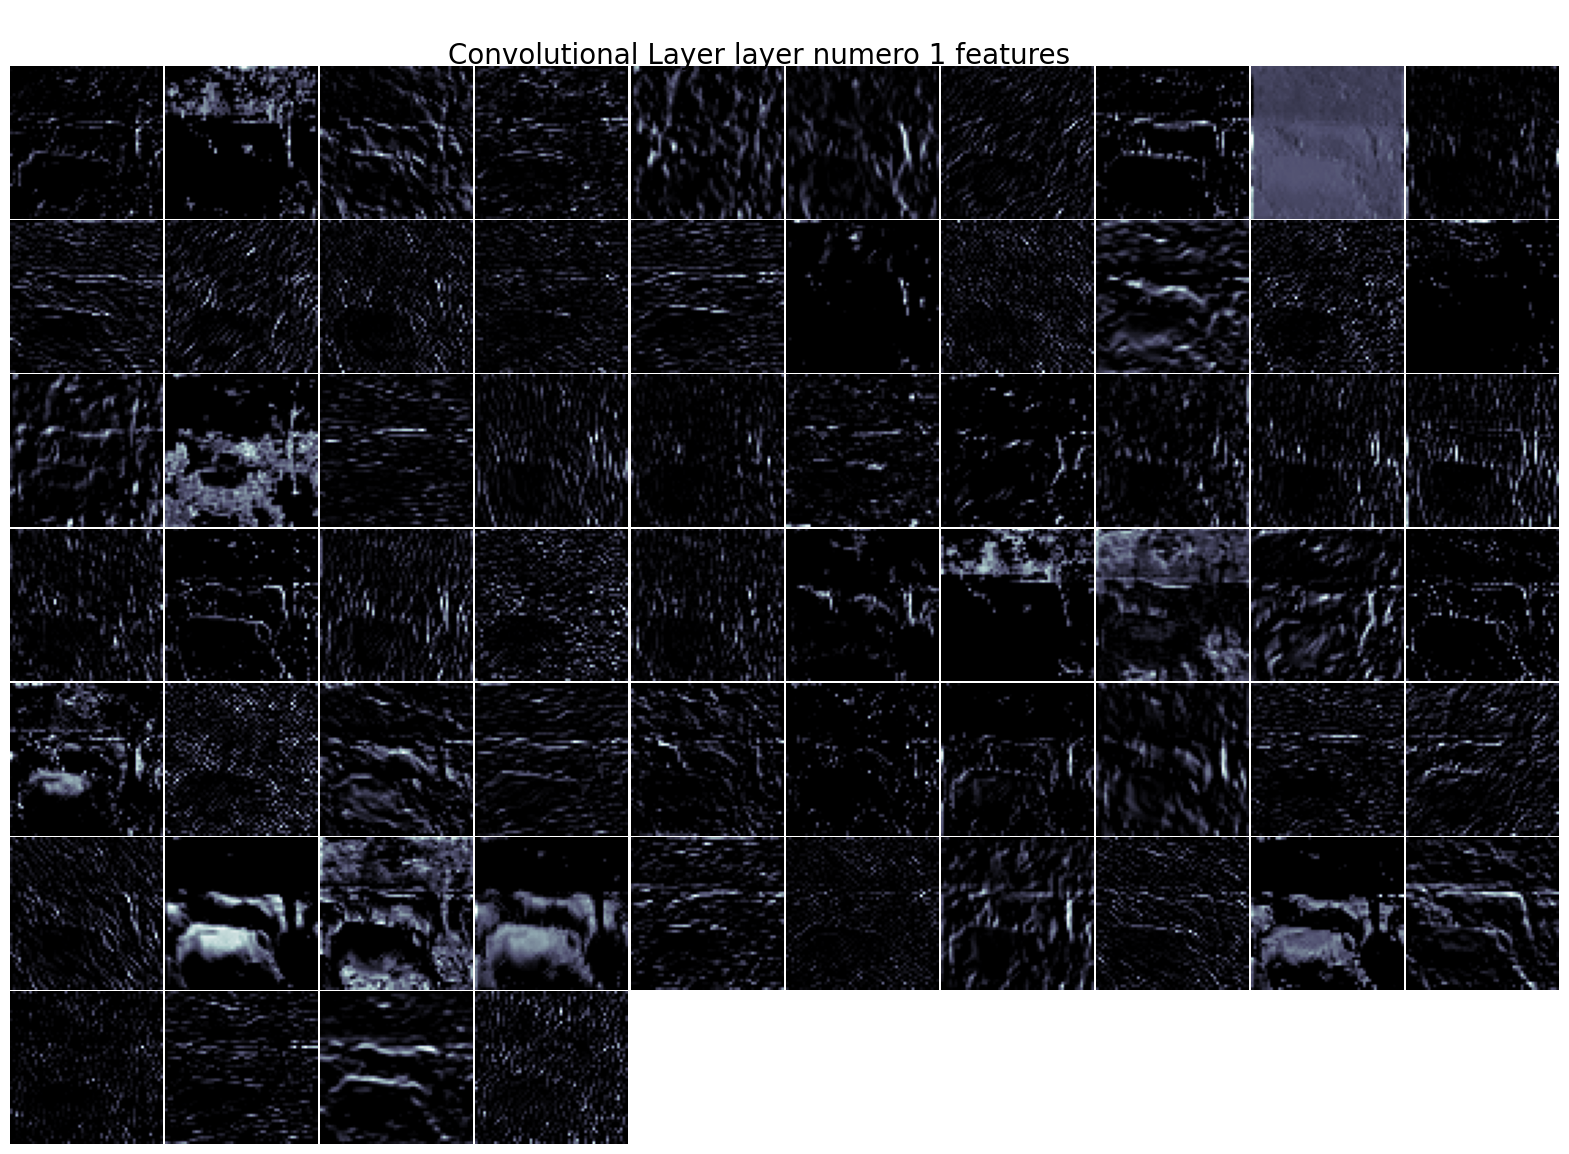

In [51]:
def plot_features(features, num_cols=10, layer_out=0, random_cmap:bool=False, layer_type:str='ReLU'):
    # Choose a single layer output to visualize
    layer_features = features[layer_out]  # For example, visualize the first layer outputs
    num_features = layer_features.shape[1]  # Number of channels in the selected layer

    num_rows = (num_features + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    cmaps = list(colormaps)
    this_cmap = cmaps[random.randint(0, len(cmaps))] if random_cmap else 'bone'
    if random_cmap:
        print (f'The Lord has decided for you to peek into feature space through the lens of {this_cmap}')
    
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        if i < num_features:
            # Normalize feature map for better visualization
            feature_map = layer_features[0, i].detach().numpy()
            feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            ax.imshow(feature_map, cmap=this_cmap)
        ax.axis('off')
    fig.suptitle(f'\n{layer_type} layer numero {layer_out+1} features', fontsize=20, y=0.92)

    # Remove space between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()


which_layer = 0
features_conv = feature_extractor_conv(img_tensor)
# features_rl = feature_extractor_rl(img_tensor)
# features_mp = feature_extractor_mp(img_tensor)
plot_features(features_conv, layer_out=which_layer, random_cmap=False, layer_type='Convolutional Layer')  # Visualize the nth layer outputs
# plot_features(features_rl, layer_out=which_layer, random_cmap=False, layer_type='ReLU')  # Visualize the nth layer outputs
# plot_features(features_mp, layer_out=which_layer, random_cmap=False, layer_type='MaxPool')  # Visualize the nth layer outputs

In [55]:
features_conv[0][0][0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2143, 0.0000, 0.0000, 0.0000, 0.7933, 0.5353, 1.8227, 0.0000, 0.3937,
        0.0000, 0.0000, 0.0335, 0.0000, 0.5097, 0.0000, 0.1728, 0.9203, 0.0000,
        0.0000, 0.4993, 0.0000, 0.7913, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1463, 0.0000, 0.0000, 0.0000, 0.0000, 1.7028, 0.4694, 0.0000, 0.4525,
        0.0000, 0.0000], grad_fn=<SelectBackward0>)

### Load in the data

In [14]:
import numpy as np
data = np.load('/home/rfpred/data/custom_files/subj01/center_strict/cnn_pcs.npz')

# The rows are the images, the columns the features
layer1_pcs = data['arr_0']  # PCs of the first layer
layer2_pcs = data['arr_1']  # PCs of the second layer
# etc.

# So these are the features for image 1 at layer 1:
layer1_pcs.shape

(35, 29)

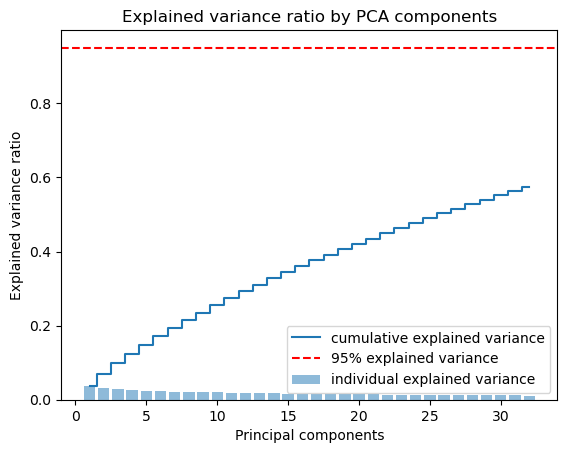

In [37]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Number of components
n_components = np.arange(1, len(ipca.explained_variance_ratio_) + 1)

# Plot the explained variance ratio
ax.bar(n_components, ipca.explained_variance_ratio_, alpha=0.5,
       align='center', label='individual explained variance')

# Plot the cumulative explained variance ratio
ax.step(n_components, cumulative_explained_variance_ratio, where='mid',
        label='cumulative explained variance')

# Add a horizontal line at y=0.95
ax.axhline(y=0.95, color='r', linestyle='--', label='95% explained variance')

# Add labels and title
ax.set_xlabel('Principal components')
ax.set_ylabel('Explained variance ratio')
ax.set_title('Explained variance ratio by PCA components')

# Add a legend
ax.legend(loc='best')

# Show the plot
plt.show()

#### This is the code from the get_cnnfeats.py file, I'm checking chunkwise what's the NaN problem

In [75]:

#!/usr/bin/env python3

import os
# Limit the number of CPUs used to 2
os.environ["OMP_NUM_THREADS"] = "5"


import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from torch.nn import Module
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)

from funcs.imgproc import rand_img_list, show_stim, get_imgs_designmx

# Load the pretrained AlexNet model
model = models.alexnet(pretrained=True)
model.eval()  # Set the model to evaluation mode

class ImageDataset(Dataset):
    def __init__(self, image_ids, transform=None):
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        imgnp = show_stim(img_no=img_id, hide='y', small = 'y')[0][163:263,163:263]
        imgPIL = Image.fromarray(imgnp) # Convert into PIL from np

        if self.transform:
            imgPIL = self.transform(imgPIL)

        return imgPIL
    
preprocess = transforms.Compose([
    transforms.Resize(227),  # Resize the image to 227x227 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
start = 1000
end = 2000
image_ids = get_imgs_designmx()['subj01'][start:end]
dataset = ImageDataset(image_ids, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

class AlexNetFeatureExtractorReLU(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractorReLU, self).__init__()
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:2])
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[2:5])
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[5:7])
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[7:9])
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[9:12])

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)

        return x1, x2, x3, x4, x5

# Initialize your model
pca_feats_relu = AlexNetFeatureExtractorReLU(model)

# Collect the features of each layer for multiple samples
features = []
batch_count = 0

for batch in dataloader:
    batch_count += 1
    print(f"Processing batch {batch_count} of {len(dataloader)}")

    img_tensor = (batch)  

    x1, x2, x3, x4, x5 = pca_feats_relu(img_tensor)
        
    features.append((x1.view(x1.size(0), -1).detach().numpy(), 
                        x2.view(x2.size(0), -1).detach().numpy(), 
                        x3.view(x3.size(0), -1).detach().numpy(), 
                        x4.view(x4.size(0), -1).detach().numpy(), 
                        x5.view(x5.size(0), -1).detach().numpy()))
    
print("Finished processing all batches")

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpr

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing batch 1 of 32
Processing batch 2 of 32
Processing batch 3 of 32
Processing batch 4 of 32
Processing batch 5 of 32
Processing batch 6 of 32
Processing batch 7 of 32
Processing batch 8 of 32
Processing batch 9 of 32
Processing batch 10 of 32
Processing batch 11 of 32
Processing batch 12 of 32
Processing batch 13 of 32
Processing batch 14 of 32
Processing batch 15 of 32
Processing batch 16 of 32
Processing batch 17 of 32
Processing batch 18 of 32
Processing batch 19 of 32
Processing batch 20 of 32
Processing batch 21 of 32
Processing batch 22 of 32
Processing batch 23 of 32
Processing batch 24 of 32
Processing batch 25 of 32
Processing batch 26 of 32
Processing batch 27 of 32
Processing batch 28 of 32
Processing batch 29 of 32
Processing batch 30 of 32
Processing batch 31 of 32
Processing batch 32 of 32
Finished processing all batches


In [76]:
pca_list = []  # List to store PCA objects for each layer
for i in range(5):
    print(f"Performing PCA on AlexNet layer {i+1}")
    layer_features = np.concatenate([feat[i] for feat in features], axis=0)
    # Scale the features

    # Initialize and fit PCA for this layer
    pca = PCA(n_components=.95, svd_solver='full')  # Adjust as needed
    layer_features_pca = pca.fit_transform(layer_features)

    pca_list.append(pca)  # Store the PCA object for later use
    
print ("Finished performing PCA on all layers")

Performing PCA on AlexNet layer 1
Performing PCA on AlexNet layer 2
Performing PCA on AlexNet layer 3
Performing PCA on AlexNet layer 4
Performing PCA on AlexNet layer 5
Finished performing PCA on all layers


In [77]:
# Initialize a new StandardScaler for each layer
scaler_list = [StandardScaler() for _ in range(5)]

# Get the PCs for each layer
pcs_list = []
for i in range(5):
    print(f"Scaling and transforming features of layer {i+1}")
    # Get the features of the i-th layer for all images
    layer_features = np.concatenate([feat[i] for feat in features], axis=0)
    # Fit and transform the StandardScaler on the features
    scaler = scaler_list[i]
    print("Before scaling:", np.isnan(layer_features).any())
    layer_features_scaled = scaler.fit_transform(layer_features)
    print("After scaling:", np.isnan(layer_features_scaled).any())
    # Get the PCA object for this layer
    pca = pca_list[i]
    # Apply PCA to the scaled features
    layer_features_pca = pca.transform(layer_features_scaled)
    # Add the PCs to the list
    pcs_list.append(layer_features_pca)
    
print("Finished scaling and transforming features of all layers")

np.savez(f'/home/rfpred/data/custom_files/subj01/center_strict/cnn_pcs{start}-{end}.npz', *pcs_list)

print('gelukt hoor')

Scaling and transforming features of layer 1
Before scaling: False
After scaling: False
Scaling and transforming features of layer 2
Before scaling: False
After scaling: False
Scaling and transforming features of layer 3
Before scaling: False
After scaling: False
Scaling and transforming features of layer 4
Before scaling: False
After scaling: False
Scaling and transforming features of layer 5
Before scaling: False
After scaling: False
Finished scaling and transforming features of all layers
gelukt hoor


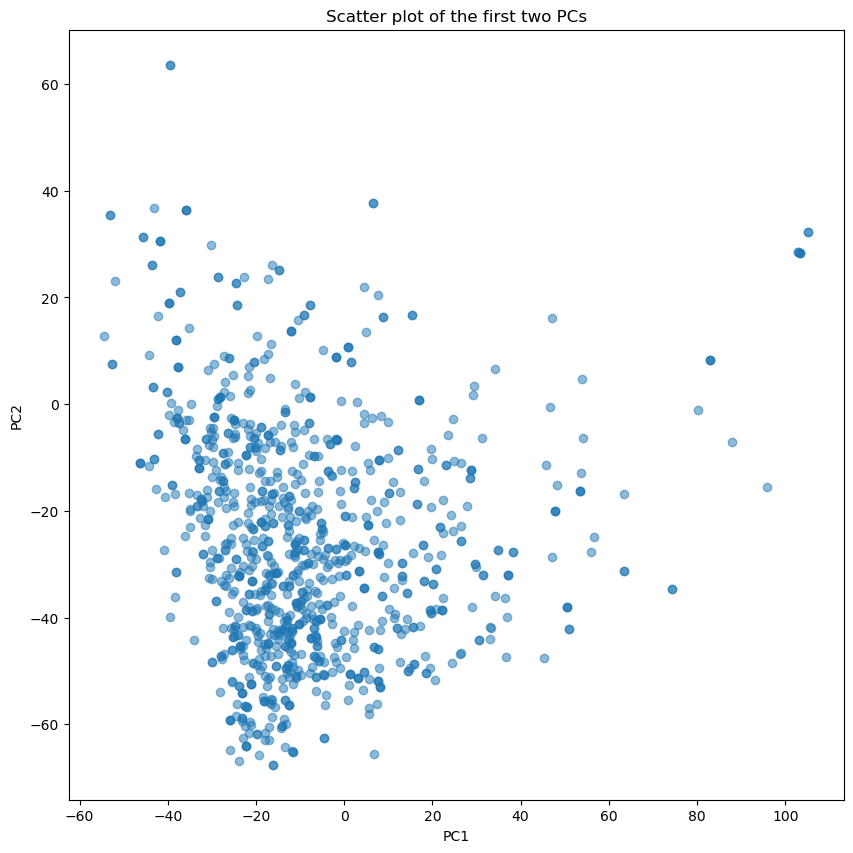

In [78]:
import matplotlib.pyplot as plt

# Assume that layer_features_pca is the output from PCA
# and it contains the PCs for the features of one layer

# Get the first two PCs
pc1 = layer_features_pca[:, 0]
pc2 = layer_features_pca[:, 1]

# Create a scatter plot of the first two PCs
plt.figure(figsize=(10, 10))
plt.scatter(pc1, pc2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot of the first two PCs')
plt.show()

####################### ONCE AGAIN A TRIAL !!!

In [80]:
import os
# Limit the number of CPUs used to 2
os.environ["OMP_NUM_THREADS"] = "5"


import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import argparse
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from torch.nn import Module
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import scipy.stats.mstats as mstats


os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)

from funcs.imgproc import rand_img_list, show_stim, get_imgs_designmx


# predparser = argparse.ArgumentParser(description='Get the AlexNet feature space neural representations for a range of images of a subject')

# predparser.add_argument('start', type=int, help='The starting index of the images to get the cnn layer specific neural represenations for')
# predparser.add_argument('end', type=int, help='The ending index of the images to get the cnn layer specific neural represenations  for')
# predparser.add_argument('subject', type=str, help='The subject to get the cnn layer specific neural represenations for')

# args = predparser.parse_args()

# print(args,'\n')


# Winsorization
def winsorize_data(data, lower_percentile=5, upper_percentile=95):
    return mstats.winsorize(data, limits=[lower_percentile / 100., upper_percentile / 100.])


# Load the pretrained AlexNet model
model = models.alexnet(pretrained=True)
model.eval()  # Set the model to evaluation mode

class ImageDataset(Dataset):
    def __init__(self, image_ids, transform=None):
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        imgnp = show_stim(img_no=img_id, hide='y', small = 'y')[0][163:263,163:263]
        imgPIL = Image.fromarray(imgnp) # Convert into PIL from np

        if self.transform:
            imgPIL = self.transform(imgPIL)

        return imgPIL
    
preprocess = transforms.Compose([
    transforms.Resize(227),  # Resize the image to 227x227 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
start = 0
end = 900
image_ids = get_imgs_designmx()['subj01'][start:end]
dataset = ImageDataset(image_ids, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

class AlexNetFeatureExtractorReLU(Module):
    def __init__(self, model):
        super(AlexNetFeatureExtractorReLU, self).__init__()
        self.features = model.features
        self.layer1 = torch.nn.Sequential(*list(self.features.children())[:2])
        self.layer2 = torch.nn.Sequential(*list(self.features.children())[2:5])
        self.layer3 = torch.nn.Sequential(*list(self.features.children())[5:7])
        self.layer4 = torch.nn.Sequential(*list(self.features.children())[7:9])
        self.layer5 = torch.nn.Sequential(*list(self.features.children())[9:12])

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)

        return x1, x2, x3, x4, x5





['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpr

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
# Initialize your model
pca_feats_relu = AlexNetFeatureExtractorReLU(model)

# Collect the features of each layer for multiple samples
features = []
batch_count = 0

for batch in dataloader:
    batch_count += 1
    print(f"Processing batch {batch_count} of {len(dataloader)}")

    img_tensor = (batch)  

    x1, x2, x3, x4, x5 = pca_feats_relu(img_tensor)
        
    features.append((x1.view(x1.size(0), -1).detach().numpy(), 
                        x2.view(x2.size(0), -1).detach().numpy(), 
                        x3.view(x3.size(0), -1).detach().numpy(), 
                        x4.view(x4.size(0), -1).detach().numpy(), 
                        x5.view(x5.size(0), -1).detach().numpy()))


print("Finished processing all batches")


Processing batch 1 of 29
Processing batch 2 of 29
Processing batch 3 of 29
Processing batch 4 of 29
Processing batch 5 of 29
Processing batch 6 of 29
Processing batch 7 of 29
Processing batch 8 of 29
Processing batch 9 of 29
Processing batch 10 of 29
Processing batch 11 of 29
Processing batch 12 of 29
Processing batch 13 of 29
Processing batch 14 of 29
Processing batch 15 of 29
Processing batch 16 of 29
Processing batch 17 of 29
Processing batch 18 of 29
Processing batch 19 of 29
Processing batch 20 of 29
Processing batch 21 of 29
Processing batch 22 of 29
Processing batch 23 of 29
Processing batch 24 of 29
Processing batch 25 of 29
Processing batch 26 of 29
Processing batch 27 of 29
Processing batch 28 of 29
Processing batch 29 of 29
Finished processing all batches


In [ ]:
print(np.min(x1))
print(np.max(x1))
print(np.count_nonzero(x1))
print(np.min(x4))
print(np.max(x4))
print(np.count_nonzero(x4))

In [82]:
############OLDCODE
pca_list = []  # List to store PCA objects for each layer

for i in range(5):
    print(f"Performing PCA on AlexNet layer {i+1}")
    layer_features = np.concatenate([feat[i] for feat in features], axis=0)
    # Scale the features
    # Check if there are any NaN values in the data
    if np.isnan(layer_features).any():
        # print("NaN values found in layer_features. Imputing with mean.")
        print("Still some NaNs in this shithole")
    layer_features = np.nan_to_num(layer_features)  # Replace NaN values with 0
    layer_features_win = winsorize_data(layer_features, lower_percentile=5, upper_percentile=95)
    # Initialize and fit PCA for this layer
    pca = PCA(n_components=600, svd_solver='full')  # Adjust as needed
    layer_features_pca = pca.fit_transform(layer_features_win)

    pca_list.append(pca)  # Store the PCA object for later use


print ("Finished performing PCA on all layers")

Performing PCA on AlexNet layer 1


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Performing PCA on AlexNet layer 2


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Performing PCA on AlexNet layer 3


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Performing PCA on AlexNet layer 4


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Performing PCA on AlexNet layer 5
Finished performing PCA on all layers


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [90]:
# Initialize a new StandardScaler for each layer
scaler_list = [StandardScaler() for _ in range(5)]

# Get the PCs for each layer
pcs_list = []
for i in range(5):
    print(f"Scaling and transforming features of layer {i+1}")
    # Get the features of the i-th layer for all images
    layer_features = np.concatenate([feat[i] for feat in features], axis=0)
    # Fit and transform the StandardScaler on the features
    scaler = scaler_list[i]
    print("Before scaling:", np.isnan(layer_features).any())
    layer_features = np.nan_to_num(layer_features)  # Replace NaN values with 0
    layer_features_win = winsorize_data(layer_features, lower_percentile=5, upper_percentile=95)

    # layer_features_scaled = scaler.fit_transform(layer_features_win)
    # print("After scaling:", np.isnan(layer_features_scaled).any())
    # Get the PCA object for this layer
    pca = pca_list[i]
    # Apply PCA to the scaled features
    # layer_features_pca = pca.transform(layer_features_scaled)
    # Add the PCs to the list
    pcs_list.append(layer_features_pca)
    
print("Finished scaling and transforming features of all layers")

np.savez(f'/home/rfpred/data/custom_files/subj01/center_strict/cnn_pcs{start}-{end}.npz', *pcs_list)

print('gelukt hoor')

Scaling and transforming features of layer 1
Before scaling: False
Scaling and transforming features of layer 2
Before scaling: False
Scaling and transforming features of layer 3
Before scaling: False
Scaling and transforming features of layer 4
Before scaling: False
Scaling and transforming features of layer 5
Before scaling: False
Finished scaling and transforming features of all layers
gelukt hoor


In [91]:
np.max(pcs_list)

0.0